#  <center> Taller  de Aprendizaje Automático </center>
##  <center> Taller 8: Demanda de bicicletas compartidas. Predicciones con *Recurrent Neural Networks*  </center>

# Introducción

Las Redes Neuronales Recurrentes o *Recurrent Neural Networks* (RNN), fueron diseñadas especialmente para aprender a partir de datos secuenciales como: audio, texto, series temporales, entre muchos otros ejemplos. Para trabajar sobre algunos conceptos fundamentales de estas redes, se recurre nuevamente al conjunto de datos [*Bike Sharing Demand*](https://www.kaggle.com/c/bike-sharing-demand). Como ya se sabe estos datos cuentan con una marca de tiempo, lo cual les da un contexto temporal. Esta información es lo que va a permitir poder tratar a estos datos como secuenciales.
A nivel del problema la idea es predecir la demanda de bicicletas en el futuro a partir de una secuencia fija de datos del pasado.


## Objetivos


*   Manipular secuencias de datos.
*   Comparar diferentes enfoques de modelos de RNN para un problema concreto.   

## Formas de trabajo

### Opción 1: Trabajar localmente

Descargar los datos en su máquina personal y trabajar en su propio ambiente de desarrollo. Asumiendo que ya creo un entorno para los talleres anteriores sólo debería installar la librería faltantes (asumiendo que está creado el ambiente y que se llama *TAA-py38*):

*conda activate TAA-py38*    
*pip install xgboost seaborn*          
*jupyter-notebook*    

Los paquetes faltantes se pueden instalar desde el notebook haciendo:     
*!pip install paquete_faltante*

### Opción 2:  Trabajar en *Colab*.

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/TAA-fing/TAA-2025/blob/main/talleres/taller8_demanda_de_bicicletas_rnn.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Ejecutar en Google Colab</a>
  </td>
</table>

Se puede trabajar en Google Colab. Para ello es necesario contar con una cuenta de **google drive** y ejecutar un notebook almacenado en dicha cuenta. De lo contrario, no se conservarán los cambios realizados en la sesión. En caso de ya contar con una cuenta, se puede abrir el notebook y luego ir a *Archivo-->Guardar una copia en drive*.

En caso de estar trabajando desde un notebook en Colab, deberá:

a) Installar el paquete *kaggle* para acceder a los datos

b) realizar la configuración necesaria para obtener datos desde la plataforma Kaggle. Para ello deberá ir a la página de la competencia y en la sección *data* aceptar los términos. Luego ejecutar la siguiente celda y pasarle el *token* de su usuario (ver comentario en celda).

In [ ]:
import warnings
warnings.filterwarnings('ignore')
from google.colab import files

# El siguiente archivo solicitado es para habilitar la API de Kaggle en el entorno que está trabajando.
# Este archivo se descarga entrando a su perfíl de Kaggle, en la sección API, presionando donde dice: Create New API Token

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

#Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 64 bytes


Una vez guardado el *token* se pueden descargar los datos.

*Nota: si los datos no se descargan (luego de ejecutar "!kaggle competitions download -c bike-sharing-demand" debería quedar un "archivo bike-sharing-demand.zip") puede deberse a que el token esté vencido. En este caso hay que volver a generar el kaggle.json.*

In [ ]:
# Descarga de datos
!kaggle competitions download -c bike-sharing-demand
!unzip bike-sharing-demand.zip
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


bike-sharing-demand.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  bike-sharing-demand.zip
replace sampleSubmission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
# opcional para visualización
#import seaborn as sns
#sns.set_theme(style="whitegrid")

In [ ]:
df_test = pd.read_csv('test.csv')
df_train_raw = pd.read_csv('train.csv')
df_submission = pd.read_csv('sampleSubmission.csv')

# Preprocesamiento de datos

## Parte 1: Separación en conjuntos de Entrenamiento y Validación, y Rellenado de Datos Faltantes

* Del conjunto de entramiento separe un conjunto de validación. Se sugiere tomar los primeros 15 días del mes para entrenar y del día 16 al 19 para validar. (*Sugerencia:* Ajuste el código de ejemplo presentado a continuación para indexar según el día).

  *Nota: Aunque no es estrictamente necesario cambiar los índices para trabajar con series temporales, es altamente recomendable porque muchas operaciones en pandas funcionan sólo cuando el índice es de tipo "datetime" (por ejemplo la función **resample**).*


Este conjunto cuenta con datos faltantes lo cual es un problema que no fue tenido en cuenta en los talleres anteriores, pero sí puede ser relevante para trabajar con secuencias. La falta de datos se debe a la inexistencia de filas, tanto en el conjunto de *train* como en el conjunto de *test* (sin tener en cuenta cómo fueron divididos estos conjuntos).

*   Completar la función presentada más abajo para rellenar los datos faltantes teniendo en cuenta que se tienen datos numéricos y categóricos. (*Sugerencias:* [*pd.DataFrame.interpolate()*](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.interpolate.html) y [*pd.DataFrame.fillna()*](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.fillna.html))


In [ ]:
## Ejemplo de indexado de datos de 2012 usando atributos de datetime

años = pd.to_datetime(df_train_raw.datetime).dt.year
# reset_index elimina el índice anterior (sino de forma predeterminada se mantiene)
df_train_2012 = df_train_raw[años == 2012].reset_index(drop=True)
print(df_train_2012.shape)
df_train_2012['datetime'] = pd.to_datetime(df_train_2012['datetime'])
df_train_2012.set_index('datetime')

(5464, 12)


,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
datetime,,,,,,,,,,,
2012-01-01 00:00:00,1,0,0,1,14.76,18.940,66,0.0000,5,43,48
2012-01-01 01:00:00,1,0,0,1,14.76,17.425,66,8.9981,15,78,93
2012-01-01 02:00:00,1,0,0,1,13.12,17.425,76,0.0000,16,59,75
2012-01-01 03:00:00,1,0,0,1,12.30,16.665,81,0.0000,11,41,52
2012-01-01 04:00:00,1,0,0,1,11.48,15.150,81,6.0032,0,8,8
...,...,...,...,...,...,...,...,...,...,...,...
2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336
2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241
2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168


In [ ]:
from datetime import datetime
import calendar

def FilledIn(df):
    df_aux = df.copy()
    df_out = pd.DataFrame(columns=df_aux.columns)
    df_aux['datetime'] = pd.to_datetime(df_aux['datetime'])
    df_aux = df_aux.set_index('datetime')

    for year in [2011, 2012]:
      for month in range(12):
        start_date = datetime(year, month+1, 1, 0, 0, 0)
        last_day_of_month = calendar.monthrange(year, month+1)[1]
        end_date = datetime(year, month+1, last_day_of_month, 23, 0, 0)
        # Se agregan las marcas de tiempo que faltan
        df_month = df_aux[start_date:end_date]
        df_month = df_month.resample('H').asfreq()
        # Rellenar los datos faltantes===========

        cat_features = ['season', 'holiday', 'workingday', 'weather']
        num_features = ['temp', 'atemp', 'humidity', 'windspeed', 'count']

        df_month[cat_features] = df_month[cat_features].fillna(method='ffill')

        df_month[num_features] = df_month[num_features].interpolate(method='linear')

        #========================================
        df_month = df_month.reset_index()

        df_out = pd.concat([df_out,df_month])
    df_out = df_out.reset_index(drop=True)
    return df_out

In [ ]:
df_train_raw.head()
dias = pd.to_datetime(df_train_raw.datetime).dt.day


train = df_train_raw[(dias >= 1) & (dias <= 16)]

val = df_train_raw[(dias >= 17) & (dias <= 19)]


adropear = ['registered','casual']
df_full_train = FilledIn(train).drop(adropear, axis=1)
df_full_val = FilledIn(val).drop(adropear,axis=1)

df_full_train

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count
0,2011-01-01 00:00:00,1.0,0.0,0.0,1.0,9.84,14.395,81.0,0.0000,16.0
1,2011-01-01 01:00:00,1.0,0.0,0.0,1.0,9.02,13.635,80.0,0.0000,40.0
2,2011-01-01 02:00:00,1.0,0.0,0.0,1.0,9.02,13.635,80.0,0.0000,32.0
3,2011-01-01 03:00:00,1.0,0.0,0.0,1.0,9.84,14.395,75.0,0.0000,13.0
4,2011-01-01 04:00:00,1.0,0.0,0.0,1.0,9.84,14.395,75.0,0.0000,1.0
...,...,...,...,...,...,...,...,...,...,...
9211,2012-12-16 19:00:00,4.0,0.0,0.0,1.0,14.76,17.425,93.0,8.9981,109.0
9212,2012-12-16 20:00:00,4.0,0.0,0.0,2.0,15.58,19.695,82.0,0.0000,122.0
9213,2012-12-16 21:00:00,4.0,0.0,0.0,2.0,14.76,18.940,93.0,0.0000,106.0
9214,2012-12-16 22:00:00,4.0,0.0,0.0,2.0,16.40,20.455,82.0,12.9980,89.0


## Parte 2: Ingeniería de características y estandarización de los datos


*   Se aplica la ingeniería de características utilizada en el Taller 3.
*   Se estandarizan los datos. Se recomienda utilizar [OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) para los datos categóricos.



In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer


# Esta clase aplica las transformaciones definidas en el método "transform"
# Todas estas transformaciones están relacionadas con el tipo de datos datetime:
# a) convierte a datetime, y separa en mes, día de la semana y hora.
# Finalmente dropea datetime porque no nos interesa.
class TimeFeatures(BaseEstimator, TransformerMixin):
  def __init__(self):
    self
  def fit(self, X, y=None):
    # X debe ser un DataFrame
    return self
  def transform(self, X):
    X_aux = X.copy()
    X_aux['datetime'] = pd.to_datetime(X_aux['datetime'])
    X_aux['month'] = X_aux['datetime'].dt.month
    X_aux['weekday'] = X_aux['datetime'].dt.weekday
    X_aux['hour'] = X_aux['datetime'].dt.hour
    X_aux = X_aux.drop('datetime', axis=1)
    return X_aux

# Conjunto de características categóricas
cat_features = ['season', 'weather', 'month', 'weekday', 'hour']

# Conjunto de características numéricas
num_features = ['temp', 'atemp', 'humidity', 'windspeed']

# [holiday, workingday] ya son onehot
# A las categóricas le aplicamos OneHotEncoder(), a las numéricas StandardScaler() y al resto nada (incluye datetime)
scaler = ColumnTransformer([('cat', OneHotEncoder(), cat_features),
                            ('num', StandardScaler(), num_features),
                            ], remainder='passthrough')


# Armamos un nuevo pipeline donde aplicamos el scaler definido antes pero primero aplicamos TimeFeatures() que definimos previamente
preprocess_pipe = Pipeline([('timefeatures', TimeFeatures()),
                            ('scaler', scaler)])


## df_full_train y df_full_val son los datos de entrenamiento y validación con los datos faltantes ya completados
df_x_train = df_full_train.copy()
print(df_x_train.shape)
df_x_val = df_full_val.copy()
print(df_x_val.shape)
X_train = preprocess_pipe.fit_transform(df_x_train.drop('count', axis=1)).toarray()
print(X_train.shape)
X_val = preprocess_pipe.transform(df_x_val.drop('count', axis=1)).toarray()
print(X_val.shape)

(9216, 10)
(1728, 10)
(9216, 57)
(1728, 57)


## Parte 3: Secuencias
Para trabajar con modelos RNN en este tipo de problemas es necesario crear un nuevo *dataset* que esté compuesto por secuencias (las secuencias de entrada al modelo) y sus correspondientes valores de *target*. Keras tiene una función muy útil para esto: la función [keras.preprocessing.timeseries_dataset_from_array()](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/timeseries_dataset_from_array).

*   Se pide crear un dataset para entrenar un modelo que permita predecir la demanda de **la próxima hora**, dado que se conocen los datos de **las últimas 24 horas**. Para evitar introducir ruido en el modelo debido a los saltos entre meses por la extracción de los datos de *test*, se sugiere crear un *tf.data.Dataset* por cada mes e ir concatenandolos a medida que se los va procesando. Puede ser útil reusar el *loop* de la función *FilledIn*.

In [ ]:
from tensorflow.keras.preprocessing import timeseries_dataset_from_array
batch_size = 32
sequence_length = 24
train_datasets = []
val_datasets = []


df_time = pd.to_datetime(df_x_train['datetime'])
train_df = pd.concat([df_time, pd.DataFrame(data=X_train)], axis=1).set_index('datetime')

df_time = pd.to_datetime(df_x_val['datetime'])
val_df = pd.concat([df_time, pd.DataFrame(data=X_val)], axis=1).set_index('datetime')

y_train = df_full_train[['count']]
y_train = y_train.set_index(pd.to_datetime(df_full_train['datetime']))

y_val = df_full_val[['count']]
y_val = y_val.set_index(pd.to_datetime(df_full_val['datetime']))



In [ ]:
import tensorflow as tf

count = 0
seq_length = 24
for year in [2011, 2012]:
    for month in range(12):
        # Indices del mes
        start_date = datetime(year, month+1, 1, 0, 0, 0)
        last_day_of_month = calendar.monthrange(year, month+1)[1]
        end_date = datetime(year, month+1, last_day_of_month, 23, 0, 0)

        X_month = train_df[start_date:end_date]
        y_month = y_train[start_date:end_date]

        dataset = tf.keras.utils.timeseries_dataset_from_array(X_month, y_month[seq_length:], sequence_length = seq_length, sequence_stride = 1, batch_size=32)

        if count < 2:
          train_ds = dataset
          count = count + 1
        else:
          train_ds = train_ds.concatenate(dataset)




        X_month = val_df[start_date:end_date]
        y_month = y_val[start_date:end_date]

        dataset = tf.keras.utils.timeseries_dataset_from_array(X_month, y_month[seq_length:], sequence_length = seq_length, sequence_stride = 1, batch_size=32)

        if count < 2:
          val_ds = dataset
          count = count + 1
        else:
          val_ds = val_ds.concatenate(dataset)




# Modelos
Para las siguientes partes se recomienda utilizar *Comet* para guardar los experimentos. Esta es una buena forma de comparar los diferentes modelos.

## Parte 4: *Naive forecasting*
De manera de tener una referencia de desempeño, en este tipo de problemas se utiliza como medida de base el desempeño de algún predictor muy simple como puede ser *Naive forecasting*. El cual simplemente predice un valor como el valor del dato anterior.

*    Calcular los valores de RMSLE y MAE para el predictor *naive forecasting* simplemente manipulando los indices del vector de *target* preprocesado (sobre los conjuntos de entrenamiento y validación).


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_log_error


y_train = df_full_train['count'].values
y_val = df_full_val['count'].values

y_train_pred = y_train[:-1]
y_train_true = y_train[1:]


y_val_pred = y_val[:-1]
y_val_true = y_val[1:]



mae_train = mean_absolute_error(y_train_true, y_train_pred)
mae_val = mean_absolute_error(y_val_true, y_val_pred)


rmsle_train = np.sqrt(mean_squared_log_error(y_train_true, y_train_pred))
rmsle_val = np.sqrt(mean_squared_log_error(y_val_true, y_val_pred))

print("=== Naive Forecasting ===")
print(f"Train MAE:   {mae_train:.4f}")
print(f"Train RMSLE: {rmsle_train:.4f}")
print(f"Val MAE:     {mae_val:.4f}")
print(f"Val RMSLE:   {rmsle_val:.4f}")


=== Naive Forecasting ===
Train MAE:   65.1613
Train RMSLE: 0.6473
Val MAE:     67.0718
Val RMSLE:   0.6435


## Parte 5: *Seq-to-Vector*
En esta parte se evaluará el desempeño de un modelo simple del tipo secuencia a vector (*seq-to-vector*) sobre el conjunto de la Parte 3. Este tipo de modelos son aquellos que reciben una secuencia a la entrada y devuelve un vector a la salida. Para esta parte se pretende que el mismo cuente con una sola capa recurrente de 64 unidades y una capa densa a la salida.

*   Crear la función de costo de manera que esta calcule el valor de RMSLE. Agregar MAE como métrica.
*   Entrenar el modelo durante 50 épocas con un optimizador *Adam* (lr=1e-3) y manteniendo el resto de los hiperparámetros por defecto. ¿Cómo es el desempeño con respecto al modelo NF?
*   Justifique la cantidad de parámetros entrenables en base a las matrices de pesos y los vectores de bias de cada capa.


In [ ]:
import tensorflow as tf

def rmsle(y_true, y_pred):
    # Asegura que los valores sean >= 0
    y_pred = tf.clip_by_value(y_pred, 0.0, tf.reduce_max(y_pred))
    y_true = tf.clip_by_value(y_true, 0.0, tf.reduce_max(y_true))

    return tf.sqrt(tf.reduce_mean(tf.square(tf.math.log1p(y_pred) - tf.math.log1p(y_true))))


In [ ]:
for x_batch, y_batch in train_ds.take(1):
    print("x_batch shape:", x_batch.shape)
    print("y_batch shape:", y_batch.shape)

x_batch shape: (32, 24, 57)
y_batch shape: (32, 1)


In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense

model = Sequential([
    SimpleRNN(64, input_shape=(24, 57)),
   Dense(1)  # salida escalar
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=rmsle,
    metrics=[tf.keras.metrics.MeanAbsoluteError()]
)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)


historysv = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[early_stopping]
)

Epoch 1/50
288/288 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 2.7387 - mean_absolute_error: 128.6785 - val_loss: 2.1144 - val_mean_absolute_error: 175.0164
Epoch 2/50
288/288 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 1.7699 - mean_absolute_error: 119.5021 - val_loss: 1.8498 - val_mean_absolute_error: 169.2160
Epoch 3/50
288/288 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 1.6033 - mean_absolute_error: 115.0940 - val_loss: 1.7092 - val_mean_absolute_error: 164.8323
Epoch 4/50
288/288 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 1.5246 - mean_absolute_error: 111.9232 - val_loss: 1.6201 - val_mean_absolute_error: 161.3026
Epoch 5/50
288/288 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 1.4822 - mean_absolute_error: 109.4978 - val_loss: 1.5585 - val_mean_absolute_error: 158.3187
Epoch 6/50
288/288 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 1.4585 - mean_absolute_error: 107.5814 - val_loss: 1.5137 - val_mean_absolute_error: 155.7520
Epoch 7/50
288/288 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 1.4456 - 

In [ ]:
train_ds

<_ConcatenateDataset element_spec=(TensorSpec(shape=(None, None, 57), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))>

((57 features + 64 neuronas + 1bias) * 64 neuronas) + (64 features que entran en la dense(1) + 1 bias)*1 salida

(57+64+1)*64 + (64+1)*1 = 7808 +65 = 7873

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 64)             │         7,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,621 (92.27 KB)

 Trainable params: 7,873 (30.75 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 15,748 (61.52 KB)

## Parte 6: *Seq-to-Seq*
Otro tipo de modelo para atacar el problema anterior son aquellos denominados secuencia a secuencia (*seq-to-seq*). Estos modelos reciben una secuencia a la entrada y devuelven una secuencia a la salida. Para este problema se puede utilizar este modelo para predecir el siguiente valor en cada celda de la red recurrente y no sólo en la última. De esta forma se puede mejorar el desempeño notablemente.
Antes de pasar al entrenamiento se debe modificar el *dataset* de manera que el *target* sea una secuencia de valores.
*    Adaptar el ejemplo 3 de la documentación de la función [keras.preprocessing.timeseries_dataset_from_array()](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/timeseries_dataset_from_array) para crear el nuevo *dataset*. Puede ser útil la siguiente función: *tf.data.Dataset.zip((features_dataset, labels_dataset))*.

*    Modificar el modelo anterior de manera que la salida de la red sea una secuencia, pero manteniendo el valor de los hiperparámetros.

*    Entrenar el nuevo modelo y comparar con los anteriores. ¿Por qué este modelo logra un desempeño mejor? ¿Por qué se mantiene la cantidad de parámetros entrenables?



In [ ]:

def mae_last_timestep(y_true, y_pred):
    y_true_last = tf.cast(y_true[:, -1], tf.float32)
    y_pred_last = tf.cast(y_pred[:, -1], tf.float32)
    return tf.reduce_mean(tf.abs(y_true_last - y_pred_last))

In [ ]:
df_time = pd.to_datetime(df_x_train['datetime'])
train_df = pd.concat([df_time, pd.DataFrame(data=X_train)], axis=1).set_index('datetime')

df_time = pd.to_datetime(df_x_val['datetime'])
val_df = pd.concat([df_time, pd.DataFrame(data=X_val)], axis=1).set_index('datetime')

y_train = df_full_train[['count']]
y_train = y_train.set_index(pd.to_datetime(df_full_train['datetime']))

y_val = df_full_val[['count']]
y_val = y_val.set_index(pd.to_datetime(df_full_val['datetime']))


In [ ]:
count = 0
seq_length = 24
for year in [2011, 2012]:
    for month in range(12):
        # Indices del mes
        start_date = datetime(year, month+1, 1, 0, 0, 0)
        last_day_of_month = calendar.monthrange(year, month+1)[1]
        end_date = datetime(year, month+1, last_day_of_month, 23, 0, 0)

        X_month = train_df[start_date:end_date]
        y_month = y_train[start_date:end_date]

        dataset = tf.keras.utils.timeseries_dataset_from_array(X_month[:-1] ,None , sequence_length = seq_length, sequence_stride = 1, batch_size=32)
        target_seq = tf.keras.utils.timeseries_dataset_from_array(y_month[1:] ,None , sequence_length = seq_length, sequence_stride = 1, batch_size=32)


        # Fusionamos X e y
        train_seq2seq_ds = tf.data.Dataset.zip((dataset, target_seq))

        if count < 2:
          train_ds_ss = train_seq2seq_ds
          count = count + 1
        else:
          train_ds_ss = train_ds_ss.concatenate(train_seq2seq_ds)




        X_month = val_df[start_date:end_date]
        y_month = y_val[start_date:end_date]

        dataset = tf.keras.utils.timeseries_dataset_from_array(X_month[:-1] ,None , sequence_length = seq_length, sequence_stride = 1, batch_size=32)
        target_seq = tf.keras.utils.timeseries_dataset_from_array(y_month[1:] ,None , sequence_length = seq_length, sequence_stride = 1, batch_size=32)


        # Fusionamos X e y
        val_seq2seq_ds = tf.data.Dataset.zip((dataset, target_seq))

        if count < 2:
          val_ds_ss = val_seq2seq_ds
          count = count + 1
        else:
          val_ds_ss = val_ds_ss.concatenate(val_seq2seq_ds)

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, TimeDistributed

model_seq2seq = Sequential([
    SimpleRNN(64, return_sequences=True, input_shape=(seq_length, 57)),
    Dense(seq_length)
])


In [ ]:
model_seq2seq.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=rmsle,
    metrics=[mae_last_timestep]
)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)


history_seq2seq = model_seq2seq.fit(
    train_ds_ss,
    validation_data=val_ds_ss,
    epochs=50,
    callbacks=[early_stopping]
)

Epoch 1/50
288/288 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 3.1427 - mae_last_timestep: 133.4838 - val_loss: 2.4262 - val_mae_last_timestep: 195.6487
Epoch 2/50
288/288 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 1.9866 - mae_last_timestep: 125.4411 - val_loss: 2.0751 - val_mae_last_timestep: 189.6444
Epoch 3/50
288/288 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 1.7412 - mae_last_timestep: 121.0060 - val_loss: 1.8907 - val_mae_last_timestep: 184.8991
Epoch 4/50
288/288 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 1.6203 - mae_last_timestep: 117.7018 - val_loss: 1.7726 - val_mae_last_timestep: 180.8735
Epoch 5/50
288/288 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 1.5503 - mae_last_timestep: 115.0661 - val_loss: 1.6898 - val_mae_last_timestep: 177.3573
Epoch 6/50
288/288 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 1.5066 - mae_last_timestep: 112.9013 - val_loss: 1.6283 - val_mae_last_timestep: 174.2020
Epoch 7/50
288/288 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 1.4778 - mae_last_timestep: 111.0

En el modelo anterior (seq-to-vector), el RNN procesaba 24 horas pero solo predecía 1 hora, lo cual desperdicia parte del contexto temporal.

En este modelo (seq-to-seq), cada paso de la RNN predice el siguiente valor, lo cual permite un entrenamiento más rico y distribuido: cada entrada tiene una salida esperada.

Esto reduce el sesgo y mejora la generalización.

return_sequences=True cambia la forma del output, no la arquitectura interna de la capa RNN.

Por lo tanto, el número de parámetros es idéntico entre SimpleRNN(64) y SimpleRNN(64, return_sequences=True).

In [ ]:
model_seq2seq.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_1 (SimpleRNN)        │ (None, 24, 64)         │         7,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 24, 24)         │         1,560 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,106 (109.79 KB)

 Trainable params: 9,368 (36.59 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 18,738 (73.20 KB)

## Parte 7: LSTM
En el modelo *seq-to-seq* sustituir la capa *SimpleRNN* por una capa LSTM


*   Entrenar la red y comparar el desempeño con los modelos anteriores.
*   Justificar la cantidad de parámetros entrenables (ver la ecuación 15-3 del libro).
*   Cambiar el largo de las secuencias. ¿Cómo varía el desempeño para este modelo?
*   ¿Es posible reducir la distancia entre las curvas *train* y *validation* con los hiperparámetros *dropout* y *recurrent_dropout*?, ¿A qué parámetros afecta cada uno?.
*   (Opcional) Probar otros métodos de regularización como penalización de los pesos. Probar cambiar otros hiperparámetros de la red.


In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, TimeDistributed, Dense

model_lstm = Sequential([
    LSTM(64, return_sequences=True, input_shape=(sequence_length, X_train.shape[1])),
    TimeDistributed(Dense(1, activation='relu'))
])
model_lstm2 = Sequential([
    LSTM(64, return_sequences=True, input_shape=(sequence_length, X_train.shape[1])),
   Dense(24)
])

In [ ]:
model_lstm.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=rmsle,
    metrics=[mae_last_timestep]
)
model_lstm2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=rmsle,
    metrics=[mae_last_timestep]
)

In [ ]:
model_lstm.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 24, 64)         │        31,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 24, 1)          │            65 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,297 (122.25 KB)

 Trainable params: 31,297 (122.25 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:


history = model_lstm.fit(
    train_seq2seq_ds,
    validation_data=val_seq2seq_ds,
    epochs=50
)


Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - loss: 1.6346 - mae_last_timestep: 183.6505 - val_loss: 1.6576 - val_mae_last_timestep: 205.0821
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 1.6254 - mae_last_timestep: 183.2626 - val_loss: 1.6496 - val_mae_last_timestep: 204.6016
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1.6165 - mae_last_timestep: 182.8783 - val_loss: 1.6420 - val_mae_last_timestep: 204.1255
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1.6081 - mae_last_timestep: 182.5106 - val_loss: 1.6348 - val_mae_last_timestep: 203.6548
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1.5999 - mae_last_timestep: 182.1482 - val_loss: 1.6278 - val_mae_last_timestep: 203.1901
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.5922 - mae_last_timestep: 181.7904 - val_loss: 1.6212 - val_mae_last_timestep: 202.7312
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 1.5847 - mae_last_timestep: 181.4371 - val_loss

In [ ]:
history = model_lstm2.fit(
    train_seq2seq_ds,
    validation_data=val_seq2seq_ds,
    epochs=50
)


Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 3.1591 - mae_last_timestep: 210.2720 - val_loss: 3.0588 - val_mae_last_timestep: 234.6560
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 3.0751 - mae_last_timestep: 209.6263 - val_loss: 2.9868 - val_mae_last_timestep: 234.0449
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 3.0043 - mae_last_timestep: 209.0265 - val_loss: 2.9251 - val_mae_last_timestep: 233.4603
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 2.9432 - mae_last_timestep: 208.4654 - val_loss: 2.8712 - val_mae_last_timestep: 232.8983
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 2.8895 - mae_last_timestep: 207.9368 - val_loss: 2.8233 - val_mae_last_timestep: 232.3563
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 2.8417 - mae_last_timestep: 207.4366 - val_loss: 2.7802 - val_mae_last_timestep: 231.8335
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 2.7985 - mae_last_timestep: 206.9597 - val_loss

In [ ]:
count = 0
seq_length = 48
for year in [2011, 2012]:
    for month in range(12):
        # Indices del mes
        start_date = datetime(year, month+1, 1, 0, 0, 0)
        last_day_of_month = calendar.monthrange(year, month+1)[1]
        end_date = datetime(year, month+1, last_day_of_month, 23, 0, 0)

        X_month = train_df[start_date:end_date]
        y_month = y_train[start_date:end_date]

        dataset = tf.keras.utils.timeseries_dataset_from_array(X_month[:-1] ,None , sequence_length = seq_length, sequence_stride = 1, batch_size=32)
        target_seq = tf.keras.utils.timeseries_dataset_from_array(y_month[1:] ,None , sequence_length = seq_length, sequence_stride = 1, batch_size=32)


        # Fusionamos X e y
        train_seq2seq_ds = tf.data.Dataset.zip((dataset, target_seq))

        if count < 2:
          train_ds_ss48 = train_seq2seq_ds
          count = count + 1
        else:
          train_ds_ss48 = train_ds_ss48.concatenate(train_seq2seq_ds)




        X_month = val_df[start_date:end_date]
        y_month = y_val[start_date:end_date]

        dataset = tf.keras.utils.timeseries_dataset_from_array(X_month[:-1] ,None , sequence_length = seq_length, sequence_stride = 1, batch_size=32)
        target_seq = tf.keras.utils.timeseries_dataset_from_array(y_month[1:] ,None , sequence_length = seq_length, sequence_stride = 1, batch_size=32)


        # Fusionamos X e y
        val_seq2seq_ds = tf.data.Dataset.zip((dataset, target_seq))

        if count < 2:
          val_ds_ss48 = val_seq2seq_ds
          count = count + 1
        else:
          val_ds_ss48 = val_ds_ss48.concatenate(val_seq2seq_ds)

In [ ]:
history48 = model_lstm.fit(
    train_ds_ss48  ,
    validation_data=val_ds_ss48,
    epochs=50
)

Epoch 1/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 13s 48ms/step - loss: 1.4286 - mae_last_timestep: 103.3445 - val_loss: 1.2937 - val_mae_last_timestep: 146.8251
Epoch 2/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - loss: 0.8548 - mae_last_timestep: 84.5163 - val_loss: 1.0175 - val_mae_last_timestep: 128.8249
Epoch 3/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 12s 47ms/step - loss: 0.7839 - mae_last_timestep: 79.3455 - val_loss: 0.9210 - val_mae_last_timestep: 119.8240
Epoch 4/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 12s 47ms/step - loss: 0.7559 - mae_last_timestep: 76.6963 - val_loss: 0.8746 - val_mae_last_timestep: 114.7448
Epoch 5/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 13s 49ms/step - loss: 0.7145 - mae_last_timestep: 73.8950 - val_loss: 0.8298 - val_mae_last_timestep: 110.2503
Epoch 6/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - loss: 0.6743 - mae_last_timestep: 71.0625 - val_loss: 0.7916 - val_mae_last_timestep: 106.6499
Epoch 7/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - loss: 0.6400 - mae_last_timestep: 68.

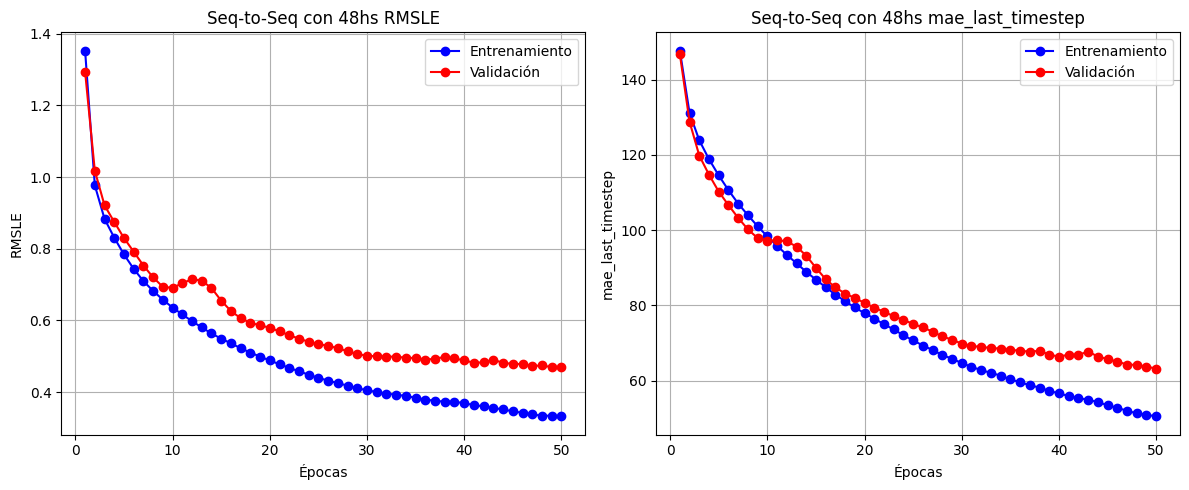

In [ ]:
def plot_metrics(history, title_prefix=''):
    history_dict = history.history
    epochs = range(1, len(history_dict['loss']) + 1)

    # Plot de RMSLE (loss)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history_dict['loss'], 'bo-', label='Entrenamiento')
    plt.plot(epochs, history_dict['val_loss'], 'ro-', label='Validación')
    plt.title(f'{title_prefix} RMSLE')
    plt.xlabel('Épocas')
    plt.ylabel('RMSLE')
    plt.legend()
    plt.grid(True)

    # Detectar la métrica (distinta de loss y val_loss)
    metric_names = [k for k in history_dict.keys() if not k.startswith('val_') and k != 'loss']
    if metric_names:
        metric = metric_names[0]
        val_metric = f'val_{metric}'

        plt.subplot(1, 2, 2)
        plt.plot(epochs, history_dict[metric], 'bo-', label='Entrenamiento')
        plt.plot(epochs, history_dict[val_metric], 'ro-', label='Validación')
        plt.title(f'{title_prefix} {metric}')
        plt.xlabel('Épocas')
        plt.ylabel(metric)
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()


# Graficar para el modelo seq-to-vector
plot_metrics(history48, title_prefix='Seq-to-Seq con 48hs')

In [ ]:
model_lstm_dropout = Sequential([
    LSTM(64, return_sequences=True,dropout=0.2,recurrent_dropout=0.2),
    TimeDistributed(Dense(1, activation='relu'))
])
model_lstm_dropout.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=rmsle,
    metrics=[mae_last_timestep]
)


history_dropout24 = model_lstm_dropout.fit(
    train_seq2seq_ds,
    validation_data=val_seq2seq_ds,
    epochs=50
)

Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 105ms/step - loss: 4.5829 - mae_last_timestep: 216.8555 - val_loss: 3.9912 - val_mae_last_timestep: 240.1238
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 3.9591 - mae_last_timestep: 214.8501 - val_loss: 3.4920 - val_mae_last_timestep: 237.3651
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 3.4748 - mae_last_timestep: 212.1234 - val_loss: 3.1684 - val_mae_last_timestep: 235.1210
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 3.1614 - mae_last_timestep: 209.8496 - val_loss: 2.9623 - val_mae_last_timestep: 233.3833
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 2.9701 - mae_last_timestep: 208.1859 - val_loss: 2.8325 - val_mae_last_timestep: 232.1108
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 2.8493 - mae_last_timestep: 207.0645 - val_loss: 2.7470 - val_mae_last_timestep: 231.2043
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 2.7611 - mae_last_timestep: 206.2818 - val_los

In [ ]:
history_dropout48 = model_lstm_dropout.fit(
    train_ds_ss48  ,
    validation_data=val_ds_ss48,
    epochs=50
)

Epoch 1/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 18s 69ms/step - loss: 1.5621 - mae_last_timestep: 113.4553 - val_loss: 1.6653 - val_mae_last_timestep: 162.5615
Epoch 2/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 18s 67ms/step - loss: 1.4997 - mae_last_timestep: 110.7880 - val_loss: 1.5972 - val_mae_last_timestep: 159.3905
Epoch 3/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 19s 71ms/step - loss: 1.4723 - mae_last_timestep: 108.7172 - val_loss: 1.5501 - val_mae_last_timestep: 156.7056
Epoch 4/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 18s 69ms/step - loss: 1.4580 - mae_last_timestep: 107.1125 - val_loss: 1.5162 - val_mae_last_timestep: 154.4572
Epoch 5/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 20s 75ms/step - loss: 1.4512 - mae_last_timestep: 105.8876 - val_loss: 1.4912 - val_mae_last_timestep: 152.5004
Epoch 6/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 18s 68ms/step - loss: 1.4488 - mae_last_timestep: 104.9618 - val_loss: 1.4725 - val_mae_last_timestep: 150.7570
Epoch 7/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 19s 72ms/step - loss: 1.4493 - mae_last_timestep

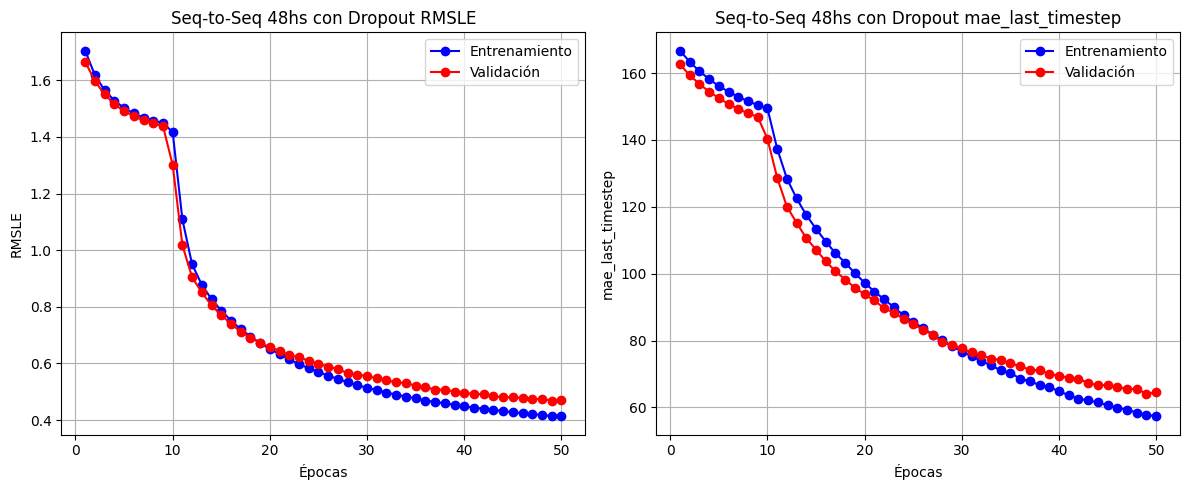

In [ ]:
def plot_metrics(history, title_prefix=''):
    history_dict = history.history
    epochs = range(1, len(history_dict['loss']) + 1)

    # Plot de RMSLE (loss)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history_dict['loss'], 'bo-', label='Entrenamiento')
    plt.plot(epochs, history_dict['val_loss'], 'ro-', label='Validación')
    plt.title(f'{title_prefix} RMSLE')
    plt.xlabel('Épocas')
    plt.ylabel('RMSLE')
    plt.legend()
    plt.grid(True)

    # Detectar la métrica (distinta de loss y val_loss)
    metric_names = [k for k in history_dict.keys() if not k.startswith('val_') and k != 'loss']
    if metric_names:
        metric = metric_names[0]
        val_metric = f'val_{metric}'

        plt.subplot(1, 2, 2)
        plt.plot(epochs, history_dict[metric], 'bo-', label='Entrenamiento')
        plt.plot(epochs, history_dict[val_metric], 'ro-', label='Validación')
        plt.title(f'{title_prefix} {metric}')
        plt.xlabel('Épocas')
        plt.ylabel(metric)
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()


# Graficar para el modelo seq-to-vector
plot_metrics(history_dropout48, title_prefix='Seq-to-Seq 48hs con Dropout')

In [ ]:
df_time = pd.to_datetime(df_x_train['datetime'])
train_df = pd.concat([df_time, pd.DataFrame(data=X_train)], axis=1).set_index('datetime')

df_time = pd.to_datetime(df_x_val['datetime'])
val_df = pd.concat([df_time, pd.DataFrame(data=X_val)], axis=1).set_index('datetime')

y_train = df_full_train[['count']]
y_train = y_train.set_index(pd.to_datetime(df_full_train['datetime']))

y_val = df_full_val[['count']]
y_val = y_val.set_index(pd.to_datetime(df_full_val['datetime']))

count = 0
seq_length = 48
for year in [2011, 2012]:
    for month in range(12):
        # Indices del mes
        start_date = datetime(year, month+1, 1, 0, 0, 0)
        last_day_of_month = calendar.monthrange(year, month+1)[1]
        end_date = datetime(year, month+1, last_day_of_month, 23, 0, 0)

        X_month = train_df[start_date:end_date]
        y_month = y_train[start_date:end_date]

        dataset = tf.keras.utils.timeseries_dataset_from_array(X_month[:-1] ,None , sequence_length = seq_length, sequence_stride = 1, batch_size=32)
        target_seq = tf.keras.utils.timeseries_dataset_from_array(y_month[1:] ,None , sequence_length = seq_length, sequence_stride = 1, batch_size=32)


        # Fusionamos X e y
        train_seq2seq_ds = tf.data.Dataset.zip((dataset, target_seq))

        if count < 2:
          train_ds_ss48 = train_seq2seq_ds
          count = count + 1
        else:
          train_ds_ss48 = train_ds_ss48.concatenate(train_seq2seq_ds)




        X_month = val_df[start_date:end_date]
        y_month = y_val[start_date:end_date]

        dataset = tf.keras.utils.timeseries_dataset_from_array(X_month[:-1] ,None , sequence_length = seq_length, sequence_stride = 1, batch_size=32)
        target_seq = tf.keras.utils.timeseries_dataset_from_array(y_month[1:] ,None , sequence_length = seq_length, sequence_stride = 1, batch_size=32)


        # Fusionamos X e y
        val_seq2seq_ds = tf.data.Dataset.zip((dataset, target_seq))

        if count < 2:
          val_ds_ss48 = val_seq2seq_ds
          count = count + 1
        else:
          val_ds_ss48 = val_ds_ss48.concatenate(val_seq2seq_ds)

In [ ]:
model_lstm_dropout2 = Sequential([
    LSTM(64, return_sequences=True,dropout=0.3,recurrent_dropout=0.25),
    TimeDistributed(Dense(1))
])
model_lstm_dropout2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=rmsle,
    metrics=[mae_last_timestep]
)


In [ ]:
history_dropout248 = model_lstm_dropout2.fit(
    train_ds_ss48  ,
    validation_data=val_ds_ss48,
    epochs=50
)

Epoch 1/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 25s 77ms/step - loss: 2.7177 - mae_last_timestep: 129.4431 - val_loss: 2.1268 - val_mae_last_timestep: 175.0769
Epoch 2/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 18s 68ms/step - loss: 1.7699 - mae_last_timestep: 120.0616 - val_loss: 1.8647 - val_mae_last_timestep: 169.1748
Epoch 3/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 19s 73ms/step - loss: 1.6065 - mae_last_timestep: 115.5846 - val_loss: 1.7259 - val_mae_last_timestep: 164.8658
Epoch 4/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 18s 68ms/step - loss: 1.5301 - mae_last_timestep: 112.4042 - val_loss: 1.6393 - val_mae_last_timestep: 161.3734
Epoch 5/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 19s 72ms/step - loss: 1.4898 - mae_last_timestep: 109.9896 - val_loss: 1.5807 - val_mae_last_timestep: 158.4213
Epoch 6/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 18s 70ms/step - loss: 1.4677 - mae_last_timestep: 108.1172 - val_loss: 1.5391 - val_mae_last_timestep: 155.9252
Epoch 7/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 20s 75ms/step - loss: 1.4557 - mae_last_timestep